In [1]:
import ROOT
from ROOT import TMath
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

Welcome to JupyROOT 6.26/02


In [104]:
import os,sys

In [102]:

'''Importing the data from the ROOT files'''

ttH = ROOT.TFile.Open("mc_341081.ttH125_gamgam.GamGam.root")
ggH = ROOT.TFile.Open("mc_343981.ggH125_gamgam.GamGam.root")
WWH = ROOT.TFile.Open("mc_345041.VBFH125_gamgam.GamGam.root")
data1 = ROOT.TFile.Open("data_A.GamGam.root")
data2 = ROOT.TFile.Open("data_B.GamGam.root")
data3 = ROOT.TFile.Open("data_C.GamGam.root")
data4 = ROOT.TFile.Open("data_D.GamGam.root")

Channels = {"ttH":ttH.Get("mini"),
            "ggH":ggH.Get("mini"),
            "WWH":WWH.Get("mini"), 
            'data1':data1.Get('mini'), 
            'data2':data2.Get('mini'),
            'data3':data3.Get('mini'),
            'data4':data4.Get('mini')
           }

for channel in Channels:
    print("Channel:",channel,"has",Channels[channel].GetEntries(),"entries")

OutputMap = {"ttH":[1,0,0,0],"ggH":[0,1,0,0],"WWH":[0,0,1,0], 
             'data1':[0,0,0,1], 'data2':[0,0,0,1], 'data3':[0,0,0,1], 'data4':[0,0,0,1]}

# Here we shall store the two photons & outputs 
dataset = []

# Prepare Data for NN
# Events are not filtered by LLT or HLT

for channel in Channels:
    print("Processing Channel ",channel)
    Channel = Channels[channel]
    counter = 0
    for event in Channel:
        #if (not event.trigP):
            #continue
        if counter > 50000:
            break
        Photons = []
        if Channel.photon_n != 2:
            continue
        for j in range(Channel.photon_n):
            Momentum = ROOT.TLorentzVector()
            Momentum.SetPtEtaPhiE(Channel.photon_pt[j]/1000., Channel.photon_eta[j],Channel.photon_phi[j],Channel.photon_E[j]/1000.)
            Photons.append(Momentum)
        Photons.sort(key = lambda p : -p.E())#sorts by energy most energetic goes first
        data = []
        for i in range(len(Photons)):
            #momentum of the photons go into nn
            data.append(Photons[i].E() )
            data.append(Photons[i].Px())
            data.append(Photons[i].Py())
            data.append(Photons[i].Pz())
        for vec in OutputMap[channel]:
            data.append(vec)
        dataset.append(data)
        counter += 1
        
        
random.shuffle(dataset)
dataset = np.asarray(dataset)

Channel: ttH has 576491 entries
Channel: ggH has 1054711 entries
Channel: WWH has 497468 entries
Channel: data1 has 430344 entries
Channel: data2 has 1528717 entries
Channel: data3 has 2237187 entries
Channel: data4 has 3602176 entries
Processing Channel  ttH
Processing Channel  ggH
Processing Channel  WWH
Processing Channel  data1
Processing Channel  data2
Processing Channel  data3
Processing Channel  data4


In [131]:
from tempfile import TemporaryFile

In [137]:
file = open('data.npy', 'w')
np.savetxt('data.csv', data, delimiter=',')

In [138]:
dataset.tofile('data')

In [141]:
np.savetxt('data.csv', dataset, delimiter=',')

In [134]:
print(type(dataset))

<class 'numpy.ndarray'>


In [4]:
len(dataset[0,:-7])

8

In [142]:
def createmodel():
    ilayer = layers.Dense(units = 7, input_dim = len(dataset[0,:-4]), activation="relu")
    layer1 = layers.Dense(units = 8, activation="relu")
    layer2 = layers.Dense(units = 9, activation="relu")
    olayer = layers.Dense(units = 4, activation = "sigmoid")

    Model = keras.Sequential([ilayer,layer1,layer2,olayer])
    
    Model.compile(
    optimizer = keras.optimizers.SGD(0.001),
    loss="binary_crossentropy"
    )
    
    return Model

Epoch 1/100
3829/3829 [==============================] - 7s 2ms/step - loss: 0.6176
Epoch 2/100
3829/3829 [==============================] - 7s 2ms/step - loss: 0.5375
Epoch 3/100
3829/3829 [==============================] - 5s 1ms/step - loss: 0.5189
Epoch 4/100
3829/3829 [==============================] - 6s 2ms/step - loss: 0.5079
Epoch 5/100
3829/3829 [==============================] - 5s 1ms/step - loss: 0.5003
Epoch 6/100
3829/3829 [==============================] - 6s 2ms/step - loss: 0.4944
Epoch 7/100
3829/3829 [==============================] - 7s 2ms/step - loss: 0.4893
Epoch 8/100
3829/3829 [==============================] - 7s 2ms/step - loss: 0.4847
Epoch 9/100
3829/3829 [==============================] - 6s 2ms/step - loss: 0.4806
Epoch 10/100
3829/3829 [==============================] - 7s 2ms/step - loss: 0.4767
Epoch 11/100
3829/3829 [==============================] - 6s 2ms/step - loss: 0.4734
Epoch 12/100
3829/3829 [==============================] - 4s 1ms/step - lo

3829/3829 [==============================] - 7s 2ms/step - loss: 0.3711
Epoch 98/100
3829/3829 [==============================] - 9s 2ms/step - loss: 0.3710
Epoch 99/100
3829/3829 [==============================] - 7s 2ms/step - loss: 0.3706
Epoch 100/100
3829/3829 [==============================] - 8s 2ms/step - loss: 0.3703


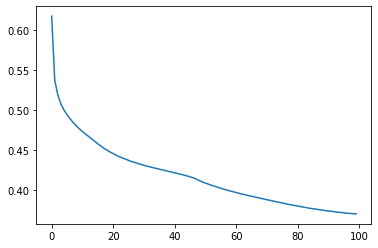

In [149]:
''' Building the NN '''

tf.keras.backend.clear_session()

fraction = 0.35
point = int(len(dataset)*fraction)

xtrain = dataset[:point,:-4]
ytrain = dataset[:point,-4:]

xtest  = dataset[point:,:-4]
ytest  = dataset[point:,-4:]

model2 = createmodel()

#saving the model
modelfolder = '/Users/dan-ioanbultoc/Desktop/EE/training/'

os.path.dirname(modelfolder)
modelsaver = tf.keras.callbacks.ModelCheckpoint(filepath = modelfolder, save_weights_only = True)

''' Training the NN '''

history = model2.fit(x = xtrain, y=ytrain, epochs=100, verbose = True, callbacks = [modelsaver])
plt.plot(history.history["loss"])
plt.show()

In [150]:
def process(prediction):#converts from % prediction to [0,0,1,0]
    for i in range(len(prediction)):
        Maxj = 0
        for j in range(len(prediction[i])):
            if prediction[i][j] > prediction[i][Maxj]:
                Maxj = j       
        prediction[i] = [0 if prediction[i][Maxj] > prediction[i][j] else 1 for j in range(len(prediction[i]))]

In [151]:
def analyzemodel(model, xtestdata, ytestdata):
    pred = model.predict(xtestdata)
    process(pred)
    
    diff = abs(pred-ytestdata)
    
    eff = 0
    for predict in diff:
        eff += 1
        for feature in predict:
            if feature != 0:
                eff -= 1
                break
    
    eff /= len(diff)
    return eff*100

In [152]:
print(analyzemodel(model2, xtrain, ytrain))

#print(ytrain[:50,:]) 

61.53777081190511


In [153]:
print(analyzemodel(model2, xtest, ytest))

61.7661150304389


In [147]:
savedmodel = createmodel()
savedmodel.load_weights(modelfolder)

In [148]:
print(ytest[0])
print(pred[0])

[0. 0. 1. 0.]
[0.2090705  0.21439794 0.24846318 0.53235114]


In [34]:
def drawhist(name, Data, filters, function):
    boundlow = 0
    boundhigh = 0
    
    for d in Data:
        skip = False
        for f in filters:
            if f(d) == False:
                skip = True
        if skip:
            continue
        g = function(d)
        if boundlow > g:
            boundlow = g
        if boundhigh < g:
            boundhigh = g
            
    
    hist = ROOT.TH1F(name, name, int(np.sqrt(len(Data))), boundlow, boundhigh)
    
    for d in Data:
        skip = False
        for f in filters:
            if f(d) == False:
                skip = True
        if skip:
            continue
        g = function(d)
        hist.Fill(g)
        
    print(boundlow)
    print(boundhigh)
    return hist

In [64]:
def eta(p):
    pt = np.sqrt(p[1]**2+p[2]**2)
    pz = p[3]
    return np.log(abs(np.tan((pt-pz)/(2*(pt+pz)))))

In [127]:
def photonpt(d):
    return np.sqrt(d[1]**2 + d[2]**2)

def invariantmass(d):
    return np.sqrt((d[0]+d[4])**2-(d[1]+d[5])**2-(d[2]+d[6])**2-(d[3]+d[7])**2)

def TInvariant(d):
    return np.sqrt(abs((d[0]-d[4])**2-(d[1]-d[5])**2-(d[2]-d[6])**2-(d[3]-d[7])**2))

def drawallhist(name, Lfunction):
    WWhist = drawhist('WWH_'+name, dataset, [lambda d: (True if d[10] == 1 else False)], lambda d: (Lfunction(d)))
    WWhist.Draw()
    ww = 'WWH'+name+'.jpeg'
    canvas.Print(str(ww))

    data1im = drawhist('dataset1'+name, dataset, [lambda d: (True if d[11] == 1 else False)], lambda d: (Lfunction(d)))
    data1im.Draw()
    ww = 'dataset1'+name+'.jpeg'
    canvas.Print(ww)

    data2im = drawhist('dataset2'+name, dataset, [lambda d: (True if d[12] == 1 else False)], lambda d: (Lfunction(d)))
    data2im.Draw()
    ww = 'dataset2'+name+'.jpeg'
    canvas.Print(ww)

    data3im = drawhist('dataset3'+name, dataset, [lambda d: (True if d[13] == 1 else False)], lambda d: (Lfunction(d)))
    data3im.Draw()
    ww = 'dataset3'+name+'.jpeg'
    canvas.Print(ww)

    data4im = drawhist('dataset4_'+name, dataset, [lambda d: (True if d[14] == 1 else False)], lambda d: (Lfunction(d)))
    data4im.Draw()
    ww = 'dataset4'+name+'.jpeg'
    canvas.Print(ww)

    ttHim = drawhist('tt'+name, dataset, [lambda d: (True if d[8] == 1 else False)], lambda d: (Lfunction(d)))
    ttHim.Draw()
    ww = 'ttH'+name+'.jpeg'
    canvas.Print(ww)

    ggHim = drawhist('gg'+name, dataset, [lambda d: (True if d[9] == 1 else False)], lambda d: (Lfunction(d)))
    ggHim.Draw()
    ww = 'ggH'+name+'.jpeg'
    canvas.Print(ww)

In [ ]:
''' old nn with only MC
Building the NN '''

tf.keras.backend.clear_session()

ilayer = layers.Dense(units = 3, input_dim = len(dataset[0,:-3]), activation="relu")
layer1 = layers.Dense(units = 8, activation="relu")
layer2 = layers.Dense(units = 9, activation="relu")
olayer = layers.Dense(units = 3, activation = "sigmoid")

#last layer has 3 nodes - 3 possibilities

model = keras.Sequential([ilayer,layer1,layer2,olayer])

fraction = 0.35
point = int(len(dataset)*fraction)

xtrain = dataset[:point,:-3]
ytrain = dataset[:point,-3:]

xtest  = dataset[point:,:-3]
ytest  = dataset[point:,-3:]

model.compile(
    optimizer = keras.optimizers.SGD(0.001),
    loss="binary_crossentropy"
    )

''' Training the NN '''

history = model.fit(x = xtrain, y=ytrain, epochs=3000, verbose = False)
plt.plot(history.history["loss"])
plt.show()